In [2]:
import twixtools
print('Hello')
full_sub_file_path = '/lustre/disk/home/shared/cusacklab/foundcog-raw/participants/ICC_103A/meas_MID00039_FID94271_cmrr_SBep2d_se_AP_RDS.dat'
twix_raw = twixtools.read_twix(full_sub_file_path)
epi_map  = twixtools.map_twix(twix_raw)

print("Measurements:", len(epi_map))





Hello
Software version: VD/VE (!?)

Scan  0


100%|██████████| 63.4M/63.4M [00:00<00:00, 807MB/s]



Scan  1


100%|██████████| 830M/830M [00:01<00:00, 851MB/s] 



Measurements: 2


In [6]:
import json
# print(json.dumps(twix_raw[1]['hdr'], indent=2))
print(twix_raw[0]['raidfile_hdr'])
print(twix_raw[1]['raidfile_hdr'])
print(epi_map[0])

(38, 94270, 10240, 67503200, b'xxxxxxxxxxxxxxxxxxxxxxx', b'AdjCoilSens')
(39, 94271, 67513856, 871717312, b'xxxxxxxxxxxxxxxxxxxxxxx', b'cmrr_SBep2d_se_AP_RDS')
{'noise': <twixtools.map_twix.twix_array object at 0x7ff87536be00>, 'image': <twixtools.map_twix.twix_array object at 0x7ff44e9c0690>, 'rt_feedback': <twixtools.map_twix.twix_array object at 0x7ff44e9c1d10>, 'hdr': {'Config': {'CPUCount': 20.0, 'MaxMemory': 122561.0, 'MaxRawObjectSize': 96371.0, 'MaxRawObjectSizePrioRecon': 3150.0, 'ProtectedSize': 3200.0, 'RAIDSize': 0.0, 'PDSFastSize': 0.0, 'PDSSaveSize': 0.0, 'NumberOfGPUs': 2.0, 'PatientID': 'xxxxxxxxxxxxxxxxxxxx', 'PatientBirthDay': 'xxxxxxxx', 'PatientSex': 1.0, 'tPatientName': 'xxxxxxxxxxxxxx', 'SubProtocolIndex': '', 'PatientLOID': '2.0.200741978', 'StudyLOID': '2.0.200741983', 'SeriesLOID': '2.0.200741987', 'ProtocolChangeHistory': '', 'tStudyDescription': '', 'relSliceNumber': '0 -1 -1 -1 -1 -1 -1 -1 -1 -1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  

In [ ]:
# Get voxel size and FOV from the first twix image
hdr = twix_raw[0]['hdr']

# Look for slice information
slice_array = hdr['MeasYaps']['sSliceArray']
print("Slice Array Keys:", slice_array.keys())

# Get slice information
if 'asSlice' in slice_array:
    first_slice = slice_array['asSlice'][0]
    print("\nFirst Slice Info:")
    print("Keys:", first_slice.keys())
    
    # Read out FOV
    if 'dReadoutFOV' in first_slice:
        print(f"\nReadout FOV: {first_slice['dReadoutFOV']} mm")
    if 'dPhaseFOV' in first_slice:
        print(f"Phase FOV: {first_slice['dPhaseFOV']} mm")
    if 'dThickness' in first_slice:
        print(f"Slice Thickness: {first_slice['dThickness']} mm")

# Get k-space parameters
kspace = hdr['MeasYaps']['sKSpace']
print("\n\nK-Space Info:")
if 'lBaseResolution' in kspace:
    print(f"Base Resolution: {kspace['lBaseResolution']}")
if 'lPhaseEncodingLines' in kspace:
    print(f"Phase Encoding Lines: {kspace['lPhaseEncodingLines']}")

# Calculate voxel size
base_res = kspace.get('lBaseResolution', None)
phase_lines = kspace.get('lPhaseEncodingLines', None)
readout_fov = first_slice.get('dReadoutFOV', None)
phase_fov = first_slice.get('dPhaseFOV', None)
thickness = first_slice.get('dThickness', None)

if base_res and phase_lines and readout_fov and phase_fov and thickness:
    voxel_size_x = readout_fov / base_res
    voxel_size_y = phase_fov / phase_lines
    voxel_size_z = thickness
    print(f"\nCalculated Voxel Size:")
    print(f"  X (readout): {voxel_size_x:.3f} mm")
    print(f"  Y (phase): {voxel_size_y:.3f} mm")
    print(f"  Z (slice): {voxel_size_z:.3f} mm")

Slice Array Keys: dict_keys(['lSize', 'lConc', 'ucMode', 'ucAnatomicalSliceMode', 'asSlice', 'sTSat'])


IndexError: list index out of range

In [153]:
# sort all 'imaging' mdbs into a k-space array
image_mdbs = [mdb for mdb in twix_raw[0]['mdb'] if mdb.is_image_scan()]
hdr = twix_raw[0]['hdr']

# Get both coil lists from header (there are 2 entries)
rx_coil_data = hdr['MeasYaps']['sCoilSelectMeas']['aRxCoilSelectData']
print(f"Number of coil groups: {len(rx_coil_data)}\n")

# Print info about each coil group
coil_groups = []
for idx, rx_coil_group in enumerate(rx_coil_data):
    coil_list = rx_coil_group['asList']
    coil_name = coil_list[0].get('sCoilElementID', {}).get('tCoilID', 'Unknown') if coil_list else 'Unknown'
    print(f"Coil group {idx} ({coil_name}): {len(coil_list)} elements")
    print(f"  Keys in coil group: {rx_coil_group.keys()}")
    coil_groups.append(coil_list)

print("\n" + "="*60)
print("Checking mdb entries to find coil group indicator:\n")

# Check several mdb entries to see what identifies the coil group
for i in [0, 1, 2, 3]:
    if i < len(image_mdbs):
        mdb = image_mdbs[i]
        print(f"MDB {i}:")
        print(f"  cLin={mdb.cLin}, cSlc={mdb.cSlc}, cRep={mdb.cRep}, cSet={mdb.cSet}")
        print(f"  Number of channels: {len(mdb.channel_hdr)}")
        
        # Check MDH for any coil group indicator
        print(f"  MDH attributes that might indicate coil group:")
        print(f"    CoilSelect: {mdb.mdh.CoilSelect if hasattr(mdb.mdh, 'CoilSelect') else 'N/A'}")
        
        # Check channel header for coil indicators
        if mdb.channel_hdr:
            ch = mdb.channel_hdr[0]
            print(f"    First channel attributes: {[attr for attr in dir(ch) if not attr.startswith('_')]}")
        print()

Number of coil groups: 2

Coil group 0 (HeadNeck_64): 34 elements
  Keys in coil group: dict_keys(['ucIndividualRFactors', 'ucNoiseDecorrMode', 'tNucleus', 'iUsedRFactor', 'IgnoreCoilGroups', 'BCCombineMode', 'bSuppressMandatoryProperties', 'asList', 'aFFT_SCALE'])
Coil group 1 (Body): 2 elements
  Keys in coil group: dict_keys(['tNucleus', 'iUsedRFactor', 'IgnoreCoilGroups', 'BCCombineMode', 'bSuppressMandatoryProperties', 'asList', 'aFFT_SCALE'])

Checking mdb entries to find coil group indicator:

MDB 0:
  cLin=1, cSlc=0, cRep=0, cSet=0
  Number of channels: 34
  MDH attributes that might indicate coil group:
    CoilSelect: 0
    First channel attributes: ['CRC', 'ChannelId', 'MeasUID', 'Reserved1', 'ScanCounter', 'SequenceTime', 'TypeAndChannelLength', 'Unused2', 'Unused3']

MDB 1:
  cLin=1, cSlc=0, cRep=0, cSet=1
  Number of channels: 2
  MDH attributes that might indicate coil group:
    CoilSelect: 1
    First channel attributes: ['CRC', 'ChannelId', 'MeasUID', 'Reserved1', 'Sc

In [ ]:
# sort all 'imaging' mdbs into a k-space array
image_mdbs = [mdb for mdb in twix_raw[-1]['mdb'] if mdb.is_image_scan()]

n_line = 1 + max([mdb.cLin for mdb in image_mdbs])

# assume that all data were acquired with same number of channels & columns:
n_channel, n_column = image_mdbs[0].data.shape

kspace = np.zeros([n_line, n_channel, n_column], dtype=np.complex64)
for mdb in image_mdbs:
    kspace[mdb.cLin] = mdb.data

In [127]:
# Look at channel IDs for all channels
print("Channel IDs from mdb:")
for i, ch_hdr in enumerate(first_mdb.channel_hdr):
    print(f"Channel {i}: ChannelId = {ch_hdr.ChannelId}")

# Check the main header for coil information
print("\n\nSearching header for coil information...")
hdr = twix_raw[0]['hdr']
recursive_search(hdr, 'Coil')
recursive_search(hdr, 'coil')
recursive_search(hdr, 'RxCoil')
recursive_search(hdr, 'asCoilSelectMeas')

Channel IDs from mdb:
Channel 0: ChannelId = 0
Channel 1: ChannelId = 1
Channel 2: ChannelId = 4
Channel 3: ChannelId = 5
Channel 4: ChannelId = 8
Channel 5: ChannelId = 9
Channel 6: ChannelId = 12
Channel 7: ChannelId = 13
Channel 8: ChannelId = 16
Channel 9: ChannelId = 17
Channel 10: ChannelId = 18
Channel 11: ChannelId = 19
Channel 12: ChannelId = 20
Channel 13: ChannelId = 21
Channel 14: ChannelId = 24
Channel 15: ChannelId = 25
Channel 16: ChannelId = 28
Channel 17: ChannelId = 29
Channel 18: ChannelId = 32
Channel 19: ChannelId = 33
Channel 20: ChannelId = 36
Channel 21: ChannelId = 37
Channel 22: ChannelId = 40
Channel 23: ChannelId = 41
Channel 24: ChannelId = 44
Channel 25: ChannelId = 45
Channel 26: ChannelId = 48
Channel 27: ChannelId = 49
Channel 28: ChannelId = 52
Channel 29: ChannelId = 53
Channel 30: ChannelId = 56
Channel 31: ChannelId = 57
Channel 32: ChannelId = 60
Channel 33: ChannelId = 61


Searching header for coil information...


In [128]:
# Search for more coil-related fields
print("Searching for coil element information...")
recursive_search(hdr, 'tCoilID')
recursive_search(hdr, 'asList')
recursive_search(hdr, 'Element')
recursive_search(hdr, 'sCoilElementID')
recursive_search(hdr, 'sRxCoilSelect')

Searching for coil element information...
FOUND: tCoilID --> 
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: tCoilID --> HeadNeck_64
FOUND: t

In [129]:
# Use find_key_paths to see the exact location
print("\nFinding exact paths for coil info...")
find_key_paths(hdr, 'tCoilID')
print("\n")
find_key_paths(hdr, 'sCoilElementID')


Finding exact paths for coil info...
FOUND at: hdr['Meas']['tCoilID'] --> 
FOUND at: hdr['MeasYaps']['sCoilSelectMeas']['aRxCoilSelectData'][0]['asList'][0]['sCoilElementID']['tCoilID'] --> HeadNeck_64
FOUND at: hdr['MeasYaps']['sCoilSelectMeas']['aRxCoilSelectData'][0]['asList'][1]['sCoilElementID']['tCoilID'] --> HeadNeck_64
FOUND at: hdr['MeasYaps']['sCoilSelectMeas']['aRxCoilSelectData'][0]['asList'][2]['sCoilElementID']['tCoilID'] --> HeadNeck_64
FOUND at: hdr['MeasYaps']['sCoilSelectMeas']['aRxCoilSelectData'][0]['asList'][3]['sCoilElementID']['tCoilID'] --> HeadNeck_64
FOUND at: hdr['MeasYaps']['sCoilSelectMeas']['aRxCoilSelectData'][0]['asList'][4]['sCoilElementID']['tCoilID'] --> HeadNeck_64
FOUND at: hdr['MeasYaps']['sCoilSelectMeas']['aRxCoilSelectData'][0]['asList'][5]['sCoilElementID']['tCoilID'] --> HeadNeck_64
FOUND at: hdr['MeasYaps']['sCoilSelectMeas']['aRxCoilSelectData'][0]['asList'][6]['sCoilElementID']['tCoilID'] --> HeadNeck_64
FOUND at: hdr['MeasYaps']['sCoilSel

In [132]:
# Check what's in MeasYaps
print("Keys in MeasYaps:", hdr['MeasYaps'].keys() if isinstance(hdr['MeasYaps'], dict) else type(hdr['MeasYaps']))
print("\nType of MeasYaps:", type(hdr['MeasYaps']))

# Try to access it correctly
if isinstance(hdr['MeasYaps'], list):
    print("\nMeasYaps is a list, checking first element...")
    print("Keys in MeasYaps[0]:", list(hdr['MeasYaps'][0].keys())[:20] if isinstance(hdr['MeasYaps'][0], dict) else "Not a dict")

Keys in MeasYaps: dict_keys(['ulVersion', 'tSequenceFileName', 'tProtocolName', 'lScanRegionPosTra', 'ucScanRegionPosValid', 'lPtabAbsStartPosZ', 'bPtabAbsStartPosZValid', 'ucTablePositioningMode', 'lContrasts', 'lCombinedEchoes', 'ucEnableIntro', 'ucDisableChangeStoreImages', 'ucAAMode', 'ucAARegionMode', 'ucAARefMode', 'ucReconstructionMode', 'ucOneSeriesForAllMeas', 'ucPHAPSMode', 'ulWrapUpMagn', 'ucReconstructionPrio', 'lAverages', 'dAveragesDouble', 'lScanTimeSec', 'lTotalScanTimeSec', 'dRefSNR', 'dRefSNR_VOI', 'ucMotionCorr', 'ucCineMode', 'ucCoilCombineMode', 'ucFlipAngleMode', 'lTOM', 'lRefProtID', 'lSequenceID', 'ucReadOutMode', 'ucBold3dPace', 'ucForcePositioningOnNDIS', 'ucTmapB0Correction', 'ucTmapEval', 'ucTmapImageType', 'ulOrganUnderExamination', 'dTissueT1', 'dTissueT2', 'lInvContrasts', 'ulReaquisitionMode', 'lDummyScans', 'ucExternalTriggerSignal', 'lSilentPeriod', 'sProtConsistencyInfo', 'sGRADSPEC', 'sTXSPEC', 'sRXSPEC', 'sAdjData', 'alTR', 'alTE', 'acFlowComp', 'sS

In [134]:
# Access coil information from the header
coil_select = hdr['MeasYaps']['sCoilSelectMeas']
print("Coil select structure:")
print("Keys:", coil_select.keys())

# Get the Rx coil data
rx_coil_data = coil_select['aRxCoilSelectData']
print(f"\nNumber of Rx coil entries: {len(rx_coil_data)}")

# Check first entry
if rx_coil_data:
    print("\nFirst Rx coil data:")
    print("Keys:", rx_coil_data[0].keys())
    
    # Look for the element list
    if 'asList' in rx_coil_data[0]:
        rx_coil_list = rx_coil_data[0]['asList']
        print(f"\nNumber of coil elements: {len(rx_coil_list)}")
        print("\nCoil element information:")
        for i, coil_elem in enumerate(rx_coil_list):
            coil_id = coil_elem.get('sCoilElementID', {}).get('tCoilID', 'N/A')
            coil_type = coil_elem.get('sCoilElementID', {}).get('tElement', 'N/A')
            print(f"  Element {i}: CoilID={coil_id}, Type={coil_type}")

Coil select structure:
Keys: dict_keys(['dOverallImageScaleFactor', 'dOverallImageScaleCorrectionFactor', 'dAutoCoilSelectIlluRangeScale', 'aRxCoilSelectData', 'aTxCoilSelectData', 'CoilPlugs'])

Number of Rx coil entries: 2

First Rx coil data:
Keys: dict_keys(['ucIndividualRFactors', 'ucNoiseDecorrMode', 'tNucleus', 'iUsedRFactor', 'IgnoreCoilGroups', 'BCCombineMode', 'bSuppressMandatoryProperties', 'asList', 'aFFT_SCALE'])

Number of coil elements: 34

Coil element information:
  Element 0: CoilID=HeadNeck_64, Type=H87
  Element 1: CoilID=HeadNeck_64, Type=H80
  Element 2: CoilID=HeadNeck_64, Type=H81
  Element 3: CoilID=HeadNeck_64, Type=H82
  Element 4: CoilID=HeadNeck_64, Type=H83
  Element 5: CoilID=HeadNeck_64, Type=H84
  Element 6: CoilID=HeadNeck_64, Type=H85
  Element 7: CoilID=HeadNeck_64, Type=H86
  Element 8: CoilID=HeadNeck_64, Type=H61
  Element 9: CoilID=HeadNeck_64, Type=H60
  Element 10: CoilID=HeadNeck_64, Type=H62
  Element 11: CoilID=HeadNeck_64, Type=H63
  Elemen

## Summary: Getting Coil Type Information

The coil information (head, body, etc.) is stored in the TWIX header under:
```python
hdr['MeasYaps']['sCoilSelectMeas']['aRxCoilSelectData'][0]['asList']
```

Each element in `asList` contains:
- **`sCoilElementID['tCoilID']`**: The coil name (e.g., "HeadNeck_64")
- **`sCoilElementID['tElement']`**: The specific element identifier (e.g., "H87", "H80", etc.)

In this dataset, all 34 channels belong to the **HeadNeck_64** coil.

In [59]:
from matplotlib import pyplot as plt
for map in epi_map:
    print(map.keys())

im_array = epi_map[0]['image']
# im_array.flags['remove_os'] = True
data = im_array[0]




dict_keys(['noise', 'image', 'rt_feedback', 'hdr', 'hdr_str'])
dict_keys(['phasecorr', 'rt_feedback', 'image', 'hdr', 'hdr_str'])


ValueError: operands could not be broadcast together with shapes (1,34,64) (2,64) (1,34,64) 

In [49]:
# some helper functions 
def ifftnd(kspace, axes=[-1]):
    if axes is None:
        axes = range(kspace.ndim)
    img = fftshift(ifftn(ifftshift(kspace, axes=axes), axes=axes), axes=axes)
    img *= np.sqrt(np.prod(np.take(img.shape, axes)))
    return img


def fftnd(img, axes=[-1]):
    if axes is None:
        axes = range(img.ndim)
    kspace = fftshift(fftn(ifftshift(img, axes=axes), axes=axes), axes=axes)
    kspace /= np.sqrt(np.prod(np.take(kspace.shape, axes)))
    return kspace

def rms_comb(sig, axis=1):
    return np.sqrt(np.sum(abs(sig)**2, axis))

# Get the MB factor from the header
def recursive_search(obj, keyname):
    if isinstance(obj, dict):
        for k, v in obj.items():
            if keyname == k:
                print("FOUND:", keyname, "-->", v)
            recursive_search(v, keyname)
    elif isinstance(obj, list):
        for item in obj:
            recursive_search(item, keyname)
            
# example usage
# hdr = twix_raw[-1]['hdr']
# recursive_search(hdr, "lMultiBandFactor")

# Alternative implementation that also shows the path to the key
def find_key_paths(obj, keyname, path="hdr"):
    if isinstance(obj, dict):
        for k, v in obj.items():
            new_path = f"{path}['{k}']"
            if k == keyname:
                print("FOUND at:", new_path, "-->", v)
            find_key_paths(v, keyname, new_path)
    elif isinstance(obj, list):
        for i, item in enumerate(obj):
            new_path = f"{path}[{i}]"
            find_key_paths(item, keyname, new_path)
# example usage
# find_key_paths(hdr, "lMultiBandFactor")
# Now we know that the MB factor is 4

(np.float64(-0.5), np.float64(63.5), np.float64(-0.5), np.float64(63.5))

<Figure size 640x480 with 0 Axes>

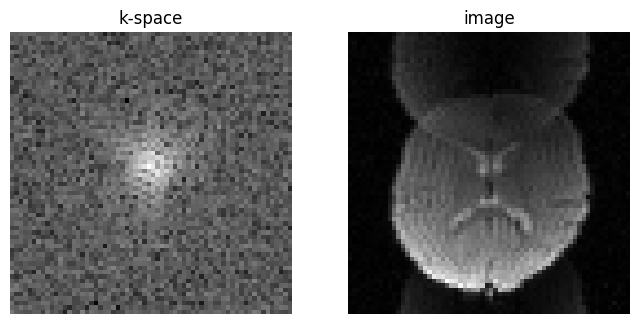

In [54]:
import numpy as np 
from numpy.fft import fftshift, ifftshift, ifftn, fftn
# define timepoint and slice to reconstruct
t = 0
slice = 10


# reconstruct the data on given sliece and timepoint and conbine coils, ifftnd to get the image from k-space
image_before = ifftnd(data[t, slice], [0, -1])
image_before = rms_comb(image_before)

plt.figure()
# plot the data
plt.figure(figsize=[8,6])
plt.subplot(121)
plt.title('k-space')
plt.imshow(abs(data[t, slice][:, 0])**0.2, cmap='gray', origin='lower')
plt.axis('off')

plt.subplot(122)
plt.title('image')
plt.imshow(image_before, cmap='gray', origin='lower')
plt.axis('off')

In [ ]:
print(epi_map[0]['image'])



twixtools.map_twix.twix_array:
  hdr: dict with header info
  mdb_list: list of Mdb objects
  shape: (1, 1, 1, 1, 1, 1, 1, 10, 1, 1, 1, 36, 1, 64, 34, 128)
  dims: ('Ide', 'Idd', 'Idc', 'Idb', 'Ida', 'Seg', 'Set', 'Rep', 'Phs', 'Eco', 'Par', 'Sli', 'Ave', 'Lin', 'Cha', 'Col')
  kspace_center_col: 64
  kspace_center_lin: 32
  kspace_center_par: 0
  fft_scale: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  rawdata_corrfactors: [1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j 1.+0.j
 1.+0.j 1.+0.j 1.+0.j 1.+0.j]
  flags:
    average: {'Ide': False, 'Idd': False, 'Idc': False, 'Idb': False, 'Ida': False, 'Seg': True, 'Set': False, 'Rep': False, 'Phs': False, 'Eco': False, 'Par': False, 'Sli': False, 'Ave': True, 'Lin': False, 'Cha': False, 'Col': False}
    remove_os: False
 

In [31]:
import numpy as np
# sort all 'imaging' mdbs into a k-space array
image_mdbs = [mdb for mdb in twix_raw[-1]['mdb'] if mdb.is_image_scan()]

n_line = 1 + max([mdb.cLin for mdb in image_mdbs])

# assume that all data were acquired with same number of channels & columns:
n_channel, n_column = image_mdbs[0].data.shape

kspace = np.zeros([n_line, n_channel, n_column], dtype=np.complex64)
for mdb in image_mdbs:
    kspace[mdb.cLin] = mdb.data

print('\nk-space shape', kspace.shape)


k-space shape (64, 34, 128)


In [6]:
# Explore the structure of twix_raw
print("Type of twix_raw:", type(twix_raw))
print("Length of twix_raw:", len(twix_raw))
print("\nType of twix_raw[0]:", type(twix_raw[0]))
print("\nKeys in twix_raw[0]:")
for key in twix_raw[0].keys():
    print(f"  - {key}")

Type of twix_raw: <class 'list'>
Length of twix_raw: 2

Type of twix_raw[0]: <class 'dict'>

Keys in twix_raw[0]:
  - mdb
  - hdr
  - hdr_str
  - raidfile_hdr
  - geometry


In [8]:
# Look at the mdb (measurement data buffer)
mdb = twix_raw[0]['mdb']
print("Type of mdb:", type(mdb))
print("Shape of mdb:", mdb.shape if hasattr(mdb, 'shape') else 'N/A')
print("\nFirst few entries in mdb:")
print(mdb[:5] if hasattr(mdb, '__getitem__') else mdb)

Type of mdb: <class 'list'>
Shape of mdb: N/A

First few entries in mdb:
[<twixtools.mdb.Mdb object at 0x7fd99c103cb0>, <twixtools.mdb.Mdb object at 0x7fd96d782490>, <twixtools.mdb.Mdb object at 0x7fd96d782710>, <twixtools.mdb.Mdb object at 0x7fd96da0dba0>, <twixtools.mdb.Mdb object at 0x7fd96da0e650>]


In [11]:
# Examine individual Mdb objects
print(f"Number of mdb entries: {len(mdb)}")
print("\nFirst Mdb object attributes:")
first_mdb = mdb[0]
print("Available attributes:", [attr for attr in dir(first_mdb) if not attr.startswith('_')])

# Look at some key attributes
print("\n--- Sample Mdb Entry ---")
print(f"data type: {type(first_mdb.data)}")
print(f"data: {first_mdb.data}")
print(f"\nmdh (measurement data header) type: {type(first_mdb.mdh)}")
print(f"mdh: {first_mdb.mdh}")

Number of mdb entries: 1843

First Mdb object attributes:
Available attributes: ['IceProgramPara', 'add_flag', 'block_len', 'cAve', 'cEco', 'cLin', 'cPar', 'cPhs', 'cRep', 'cSeg', 'cSet', 'cSlc', 'channel_hdr', 'clear_all_flags', 'convert_to_local', 'data', 'data_len', 'dma_len', 'fid', 'get_active_flags', 'get_flag', 'get_flags', 'is_flag_set', 'is_image_scan', 'mdh', 'mem_pos', 'remove_flag', 'set_flag', 'set_flags', 'set_pmutimestamp', 'set_timestamp', 'set_timestamps', 'update_CRC', 'version_is_ve', 'write_to_file']

--- Sample Mdb Entry ---
data type: <class 'twixtools.seqdata.SeqData'>
data: SeqData(packet_size=1466, id=AdjCoilSensSeq:AdjContext+AdjResult.setup, swapped=0)

mdh (measurement data header) type: <class 'twixtools.mdh_def.Scan_header'>
mdh: [1728, 0, 270996696, 32750, 270960016, 32750, 0, 959818795, 0, 1311, 0, 40, 10567, 29724, [32750, 0, 0, 0, 0, 0, 1311, 0, 0, 0, 18648, 14903, 32751, 0], [10592, 29724], 32750, 0, 4.2063792449198445e-08, 32751, 0, 0, ['[0.0, 3.2951

In [13]:
# Explore MDH (measurement data header) fields
print("MDH attributes:")
mdh_attrs = [attr for attr in dir(first_mdb.mdh) if not attr.startswith('_')]
print(mdh_attrs)

print("\n--- Key MDH fields ---")
print(f"Line counter (cLin): {first_mdb.cLin}")
print(f"Partition counter (cPar): {first_mdb.cPar}")
print(f"Slice counter (cSlc): {first_mdb.cSlc}")
print(f"Echo counter (cEco): {first_mdb.cEco}")
print(f"Phase counter (cPhs): {first_mdb.cPhs}")
print(f"Repetition counter (cRep): {first_mdb.cRep}")
print(f"Set counter (cSet): {first_mdb.cSet}")
print(f"Segment counter (cSeg): {first_mdb.cSeg}")
print(f"Average counter (cAve): {first_mdb.cAve}")

MDH attributes:
['ApplicationCounter', 'ApplicationMask', 'CRC', 'CenterCol', 'CenterLin', 'CenterPar', 'CoilSelect', 'Counter', 'CutOff', 'EvalInfoMask', 'FlagsAndDMALength', 'IceProgramPara', 'MeasUID', 'PMUTimeStamp', 'PTABPosDelay', 'PTABPosX', 'PTABPosY', 'PTABPosZ', 'ReadOutOffcentre', 'Reserved1', 'ReservedPara', 'SamplesInScan', 'ScanCounter', 'SliceData', 'SystemType', 'TimeSinceLastRF', 'TimeStamp', 'UsedChannels']

--- Key MDH fields ---
Line counter (cLin): 32750
Partition counter (cPar): 0
Slice counter (cSlc): 0
Echo counter (cEco): 0
Phase counter (cPhs): 0
Repetition counter (cRep): 1311
Set counter (cSet): 0
Segment counter (cSeg): 0
Average counter (cAve): 0


In [96]:
# Check flags for different scan types
print("Checking flags across mdb entries:\n")

# Sample a few entries
sample_indices = [0, 100, 500, 1000, 1500, len(mdb)-1]
for idx in sample_indices:
    entry = mdb[idx]
    flags = entry.get_active_flags()
    print(f"Entry {idx}: cLin={entry.cLin}, cSlc={entry.cSlc}, cRep={entry.cRep}")
    print(f"  Active flags: {flags}")
    print(f"  Is image scan: {entry.is_image_scan()}")
    print()

Checking flags across mdb entries:



TypeError: object of type 'Mdb' has no len()

In [17]:
print(epi_map[0].keys())
print(epi_map[1].keys())

dict_keys(['noise', 'image', 'rt_feedback', 'hdr', 'hdr_str'])
dict_keys(['phasecorr', 'rt_feedback', 'image', 'hdr', 'hdr_str'])
